<a href="https://colab.research.google.com/github/asarria48/Nuclear-physics/blob/main/Informe3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparación

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from datetime import datetime
import os

Para saber dónde ubicar los picos, puedo hacerme primero una idea de la relación energía-canal

<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1413952964.py:17: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)


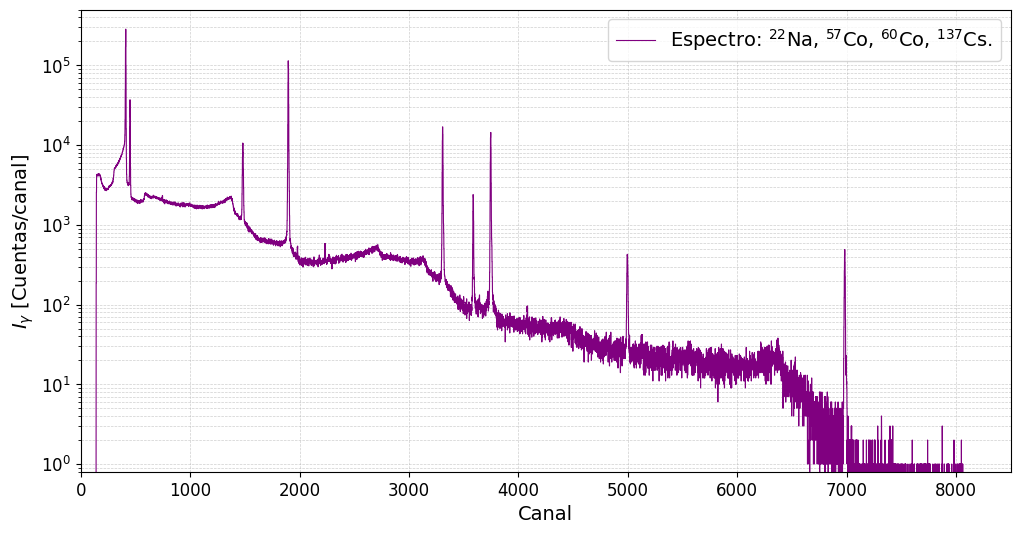

In [5]:
varios = pd.read_csv("calibracionNaCoCoCs-Ge8K.xy", sep=r"\s+", header=None)

varios.columns = ["canal", "cuentas"]

df = varios

plt.figure(figsize=(12,6))
plt.plot(df["canal"], df["cuentas"], ds="steps-mid", color='purple', lw=0.8, label="Espectro: $^{22}$Na, $^{57}$Co, $^{60}$Co, $^{137}$Cs.")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.xlim(0, 8500)
plt.yscale("log")
plt.ylim(0.8, 5e5)

plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()


Recurro a algunos de los picos que pueda ubicar "a ojo"


μ        = 410.622(32)
σ        = 1.638(35)
FWHM     = 3.843(81)
Int      = 1126820(31)


<>:63: SyntaxWarning: invalid escape sequence '\g'
<>:63: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3110575971.py:63: SyntaxWarning: invalid escape sequence '\g'
  ax.set_ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)


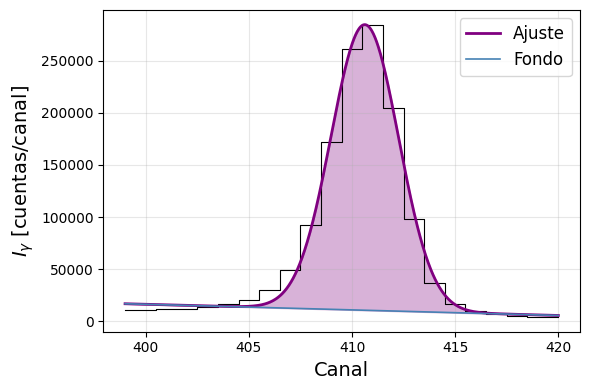


μ        = 1896.497(20)
σ        = 2.194(21)
FWHM     = 5.147(49)
Int      = 626675(77)


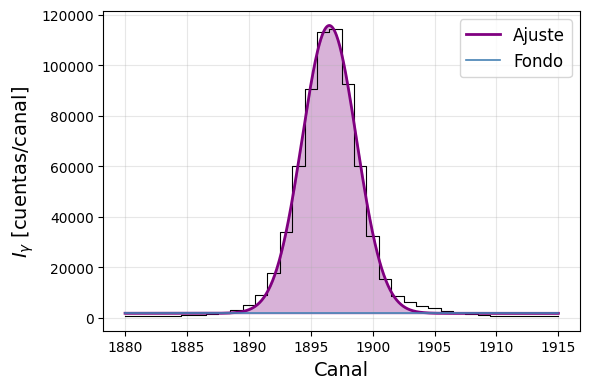


μ        = 3307.219(16)
σ        = 2.483(18)
FWHM     = 5.825(42)
Int      = 102044(94)


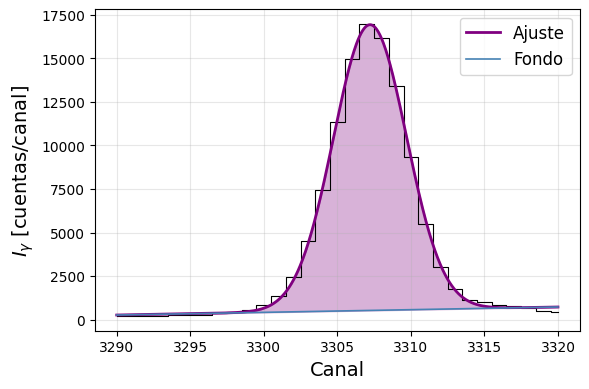


μ        = 3746.453(15)
σ        = 2.569(17)
FWHM     = 6.026(39)
Int      = 91685(75)


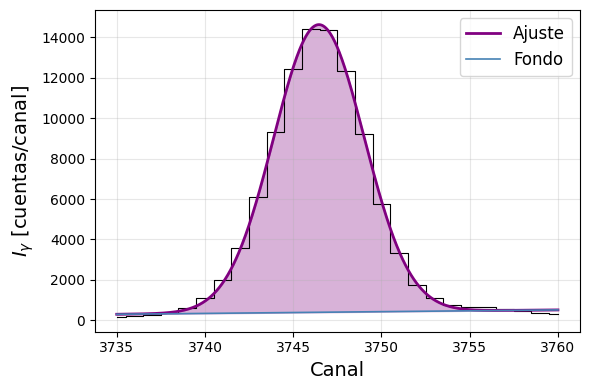


μ        = 3586.634(25)
σ        = 2.519(28)
FWHM     = 5.908(65)
Int      = 14616(21)


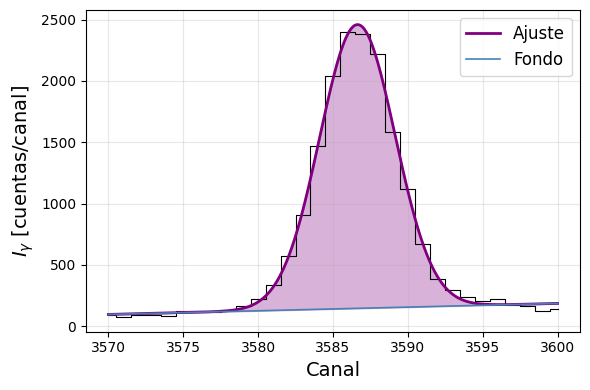

In [14]:
def leer_xy(archivo):
    return pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])


def gauss_bg(x, mu, sigma, A, a0, a1):                                          # gaussiana con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x

def fwhm(sigma): return 2.3458 * sigma
def dfwhm(dsigma): return 2.3458 * dsigma
def intensidad(A, sigma): return A * sigma * np.sqrt(2*np.pi)
def dintensidad(A, sigma, dA, dsigma):
    return np.sqrt((sigma*np.sqrt(2*np.pi)*dA)**2 + (A*np.sqrt(2*np.pi)*dsigma)**2)

def format_unc(value, error):
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


# ajustes en general
def ajustar_pico(x, y, x_min, x_max, color="purple"):

    mask = (x >= x_min) & (x <= x_max)
    xr, yr = x[mask], y[mask]

    mu_guess = xr[np.argmax(yr)]
    A_guess = yr.max()
    p0 = [mu_guess, 4.0, A_guess, np.median(yr), 0.0]

    popt, pcov = curve_fit(gauss_bg, xr, yr, p0=p0, maxfev=10000)
    perr = np.sqrt(np.diag(pcov))

    mu, sigma, A, a0, a1 = popt
    dmu, dsigma, dA, da0, da1 = perr

    print(f"\n======")
    labels = ["μ", "σ", "FWHM", "Int"]
    vals   = [mu, sigma, fwhm(sigma), intensidad(A, sigma)]
    errs   = [dmu, dsigma, dfwhm(dsigma), dintensidad(A, sigma, dA, dsigma)]

    for l, v, e in zip(labels, vals, errs):
        print(f"{l:8s} = {format_unc(v, e)}")

    xf = np.linspace(xr.min(), xr.max(), 800)
    fit = gauss_bg(xf, *popt)
    bg  = a0 + a1 * xf

    # gráficas
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(xr, yr, where='mid', color='black', lw=0.8)
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\gamma$ [cuentas/canal]", fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)


    plt.tight_layout()
    plt.show()


# ajusto varios picos de una vez

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)
x, y = data["canal"].values, data["cuentas"].values

picos = [
    (399, 420, "purple"),                                                       # del cobalto 57 (lo sé por el informe pasado, está antes de todos) 122 keV
    (1880, 1915, "purple"),                                                     # del cesio 137 (no el pico de rayos X) 661 keV
    (3290, 3320, "purple"),                                                     # del cobalto 60 (primero) 1173 keV
    (3735, 3760, "purple"),                                                     # del cobalto 60 (segundo) 1332 keV
    (3570, 3600, "purple"),                                                     # del sodio 22, 1275 keV
]

for xmin, xmax, color in picos:
    ajustar_pico(x, y, xmin, xmax, color)


Hago un ajuste preliminar para hacerme una idea de la conversión de canal a keV

=== Ajuste de canal vs energía ===
b0 = 73.598 ± 0.992
b1 = 2.75623 ± 0.00097
-0.0008586685813530997

=== Resultados de la calibración en energía ===
a0 = -26.70(036) keV
a1 = 0.36281(000) keV/canal

Ecuación de calibración:
E = -26.70(036) + 0.36281(000) * canal
Acomodar la incertidumbre de a0 a (2) y despreciar la de a1.


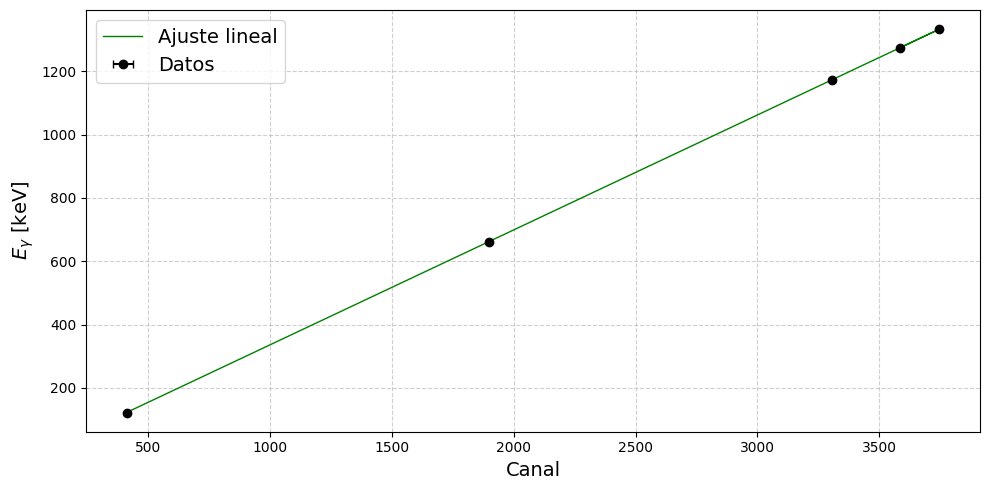


=== Comparación Energía Teórica vs Ajustada ===
   Canal    E_teórico (keV)     E_ajustado (keV)     ΔE (keV)    Error %
  410.62            122.100              122.277       -0.177      0.145
 1896.49            661.700              661.372        0.328      0.050
 3307.22           1173.200             1173.205       -0.005      0.000
 3746.45           1332.500             1332.565       -0.065      0.005
 3586.63           1274.500             1274.581       -0.081      0.006

=== Tabla: Resolución de picos === solo tomar FWHM de acá
 E_teórico (keV)    σ (canales)     FWHM (canales)     FWHM (keV)   Resolución (%)
          122.10          1.341              3.158          1.146             0.94
          661.70          1.384              3.259          1.182             0.18
         1173.20          1.726              4.064          1.474             0.13
         1332.50          2.053              4.834          1.754             0.13
         1274.50          2.244        

In [15]:

E = np.array([122.1, 661.7, 1173.2, 1332.5, 1274.5])
mu = np.array([410.622, 1896.49, 3307.219, 3746.453, 3586.634])
dmu = np.array([0.032, 0.02, 0.016, 0.015, 0.025])
dE = np.ones_like(E)


def f(E, b0, b1):
    return b0 + b1 * E                                                                                # canal = b0 + b1 * energía

popt, pcov = curve_fit(f, E, mu, sigma=dE, absolute_sigma=True)
b0, b1 = popt
db0, db1 = np.sqrt(np.diag(pcov))

print("=== Ajuste de canal vs energía ===")
print(f"b0 = {b0:.3f} ± {db0:.3f}")
print(f"b1 = {b1:.5f} ± {db1:.5f}")
print(pcov[0,1])

# invierto
# E = a0 + a1 * canal
a1 = 1 / b1
a0 = -b0 / b1
da1 = db1 / b1**2
da0 = np.sqrt((db0/b1)**2 + (b0*db1/b1**2)**2)


def format_uncertainty(value, uncertainty):
    n_decimals = int(-np.floor(np.log10(uncertainty))) + 1
    value_rounded = round(value, n_decimals)
    uncertainty_rounded = round(uncertainty, n_decimals)
    digits = str(uncertainty_rounded).replace('.', '')[:3]
    return f"{value_rounded:.{n_decimals}f}({digits})"

a0_str = format_uncertainty(a0, da0)
a1_str = format_uncertainty(a1, da1)

print("\n=== Resultados de la calibración en energía ===")
print(f"a0 = {a0_str} keV")
print(f"a1 = {a1_str} keV/canal")
print(f"\nEcuación de calibración:")
print(f"E = {a0_str} + {a1_str} * canal")
print(f"Acomodar la incertidumbre de a0 a (2) y despreciar la de a1.")


plt.figure(figsize=(10,5))
plt.errorbar(mu, E, xerr=dmu, fmt='o', color='black', capsize=3, label='Datos')
plt.plot(mu, a0 + a1*mu, color='green', lw=1, label='Ajuste lineal')
plt.xlabel('Canal', fontsize=14)
plt.ylabel('$E_{\\gamma}$ [keV]', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()


E_ajustado = a0 + a1 * mu
dif = E - E_ajustado
error_rel = np.abs(dif / E) * 100

print("\n=== Comparación Energía Teórica vs Ajustada ===")
print(f"{'Canal':>8} {'E_teórico (keV)':>18} {'E_ajustado (keV)':>20} {'ΔE (keV)':>12} {'Error %':>10}")
for i in range(len(E)):
    print(f"{mu[i]:8.2f} {E[i]:18.3f} {E_ajustado[i]:20.3f} {dif[i]:12.3f} {error_rel[i]:10.3f}")


# me falta calcular FHWM [keV]
sigma = np.array([1.341, 1.384, 1.7258, 2.053, 2.244, 2.434, 2.71, 1.638, 2.173, 2.46, 2.57, 3.188])         # ejemplo: σ en canales para cada pico
d_sigma = np.array([0.015, 0.012, 0.0081, 0.014, 0.021, 0.017, 0.04, 0.035, 0.022, 0.02, 0.02, 0.072])                                         # incertidumbre en σ

# FWHM en canales
FWHM_canal = 2.35482 * sigma
dFWHM_canal = 2.35482 * d_sigma

# FWHM en energía (keV)
FWHM_E = a1 * FWHM_canal
dFWHM_E = a1 * dFWHM_canal

# === Mostrar tabla resumen ===
print("\n=== Tabla: Resolución de picos === solo tomar FWHM de acá")
print(f"{'E_teórico (keV)':>16} {'σ (canales)':>14} {'FWHM (canales)':>18} {'FWHM (keV)':>14} {'Resolución (%)':>16}")
for i in range(len(E)):
    resol = (FWHM_E[i] / E[i]) * 100
    print(f"{E[i]:16.2f} {sigma[i]:14.3f} {FWHM_canal[i]:18.3f} {FWHM_E[i]:14.3f} {resol:16.2f}")


Usando ese ajuste, puedo ubicar bien cada energía propuesta en los espectros. También el del europio

In [ ]:
E = 964.1                            # meto aquí cada energía propuesta en las tablas, recibo alrededor de dónde está el pico y puedo terminar de ubicarlo a ojo.
Canal = 73.598 + 2.75623 * E
print(Canal)

2730.879343


<>:42: SyntaxWarning: invalid escape sequence '\g'
<>:42: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-4243855817.py:42: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)


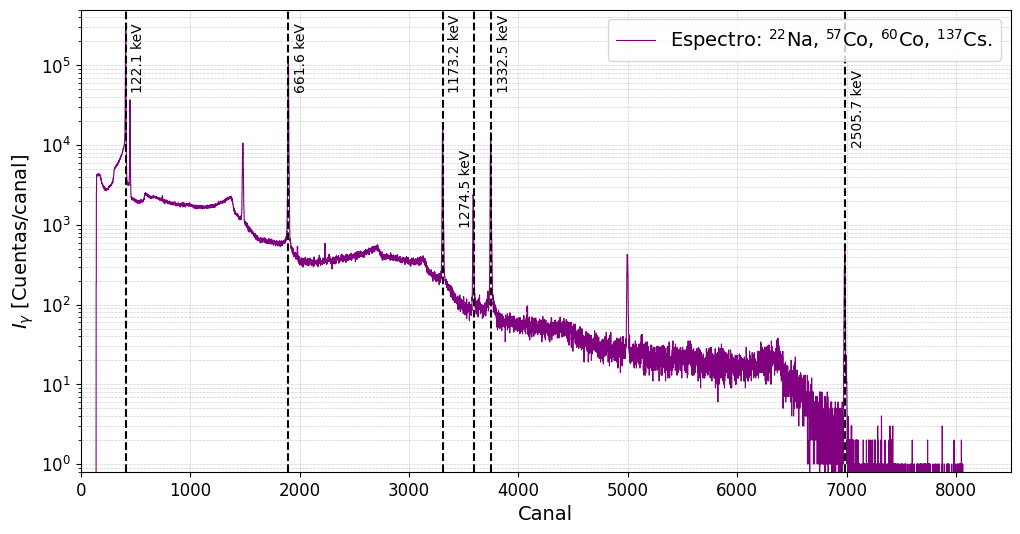

In [ ]:
# leo los espectros
varios = pd.read_csv("calibracionNaCoCoCs-Ge8K.xy", sep=r"\s+", header=None)
euro = pd.read_csv("calibracionEu-Ge8K.xy", sep=r"\s+", header=None)

# nombres de columnas
varios.columns = ["canal", "cuentas"]
euro.columns = ["canal", "cuentas"]

df = varios                                                                     # por ahora solo me interesan estos espectros

plt.figure(figsize=(12,6))
plt.plot(df["canal"], df["cuentas"], ds="steps-mid", color='purple', lw=0.8, label="Espectro: $^{22}$Na, $^{57}$Co, $^{60}$Co, $^{137}$Cs.")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

# aquí meto los picos "a ojo" que ya conozco

plt.axvline(410, color='black', lw=1.5,linestyle='--')
plt.text(410 + 50, 1e4*5, f'122.1 keV', color='black',rotation=90, fontsize=10)     # del cobalto 57

plt.axvline(1895, color='black', lw=1.5,linestyle='--')
plt.text(1895 + 50, 1e4*5, f'661.6 keV', color='black',rotation=90, fontsize=10)    # del cesio 137

plt.axvline(3310, color='black', lw=1.5,linestyle='--')
plt.text(3310 + 50, 1e4*5, f'1173.2 keV', color='black',rotation=90, fontsize=10)   # "primero" del cobalto 60

plt.axvline(3750, color='black', lw=1.5,linestyle='--')
plt.text(3750 + 50, 1e4*5, f'1332.5 keV', color='black',rotation=90, fontsize=10)   # "segundo" del cobalto 60

plt.axvline(6985, color='black', lw=1.5,linestyle='--')
plt.text(6985 + 50, 1e4, f'2505.7 keV', color='black', rotation=90, fontsize=10)    # resultado de la suma de los dos picos del cobalto 60

plt.axvline(3590, color='black', lw=1.5,linestyle='--')
plt.text(3590 - 130, 1e3, f'1274.5 keV', color='black',rotation=90, fontsize=10)    # del sodio 22


plt.xlim(0, 8500)
plt.yscale("log")
plt.ylim(0.8, 5e5)

plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()


Para el Europio

<>:50: SyntaxWarning: invalid escape sequence '\g'
<>:50: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-424796343.py:50: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)


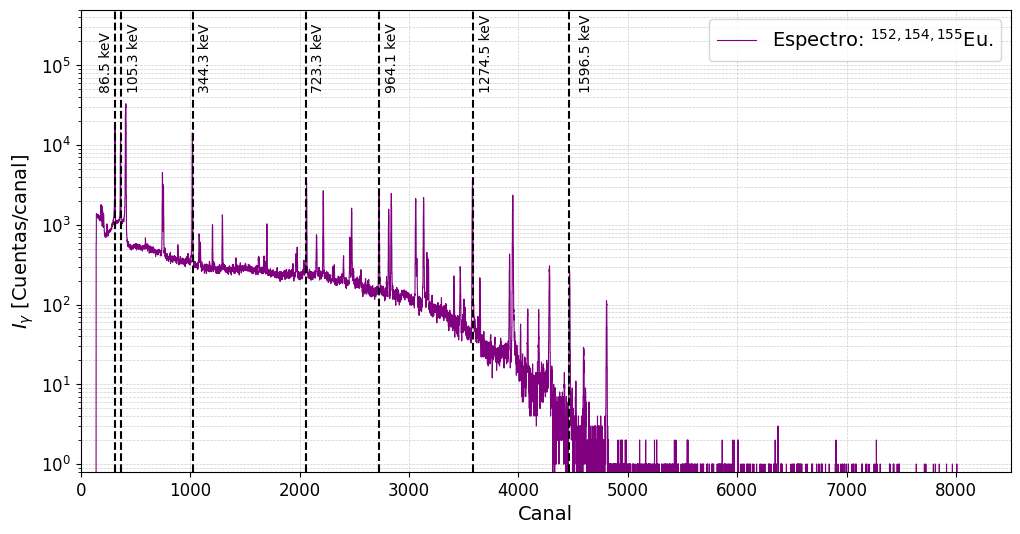

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# leo los espectros
varios = pd.read_csv("calibracionNaCoCoCs-Ge8K.xy", sep=r"\s+", header=None)
euro = pd.read_csv("calibracionEu-Ge8K.xy", sep=r"\s+", header=None)

# nombres de columnas
varios.columns = ["canal", "cuentas"]
euro.columns = ["canal", "cuentas"]

df = euro                                                                       # cambio de varios a euro

plt.figure(figsize=(12,6))
plt.plot(df["canal"], df["cuentas"], ds="steps-mid", color='purple', lw=0.8, label="Espectro: $^{152,154,155}$Eu.")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

# aquí meto los picos "a ojo" que ya conozco

plt.axvline(312.14, color='black', lw=1.5,linestyle='--')
plt.text(312.14 - 150, 1e4*5, f'86.5 keV', color='black',rotation=90, fontsize=10)

plt.axvline(370, color='black', lw=1.5,linestyle='--')
plt.text(370 + 50, 1e4*5, f'105.3 keV', color='black',rotation=90, fontsize=10)

plt.axvline(1025, color='black', lw=1.5,linestyle='--')
plt.text(1025 + 50, 1e4*5, f'344.3 keV', color='black',rotation=90, fontsize=10)

plt.axvline(2055, color='black', lw=1.5,linestyle='--')
plt.text(2055 + 50, 1e4*5, f'723.3 keV', color='black',rotation=90, fontsize=10)

plt.axvline(2730, color='black', lw=1.5,linestyle='--')
plt.text(2730 + 50, 1e4*5, f'964.1 keV', color='black', rotation=90, fontsize=10)

plt.axvline(3585, color='black', lw=1.5,linestyle='--')
plt.text(3585 + 50, 1e4*5, f'1274.5 keV', color='black',rotation=90, fontsize=10)

plt.axvline(4460, color='black', lw=1.5,linestyle='--')
plt.text(4500 + 50, 1e4*5, f'1596.5 keV', color='black',rotation=90, fontsize=10)

#plt.axvline(2730.8, color='red', lw=1.5,linestyle='--')

plt.xlim(0, 8500)
plt.yscale("log")
plt.ylim(0.8, 5e5)

plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()


# Calibraciones

# Para NaCoCoCs

Cobalto 57, 122.1 keV


=== Parámetros ===
μ        = 410.622(32)
σ        = 1.638(35)
FWHM     = 3.843(81)
Int      = 1126820(31)


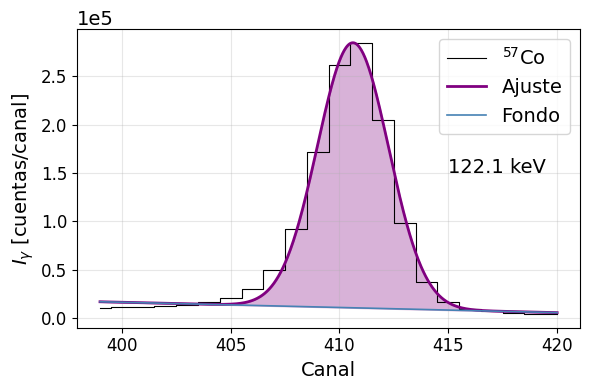

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

# Pico de 122 keV
x_min, x_max = 399, 420
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{57}$Co)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='$^{57}$Co')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(415, 1.5*1e5, '122.1 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Cesio 137, 661.7 keV


=== Parámetros ===
μ        = 1896.497(20)
σ        = 2.173(22)
FWHM     = 5.097(52)
Int      = 617917(81)


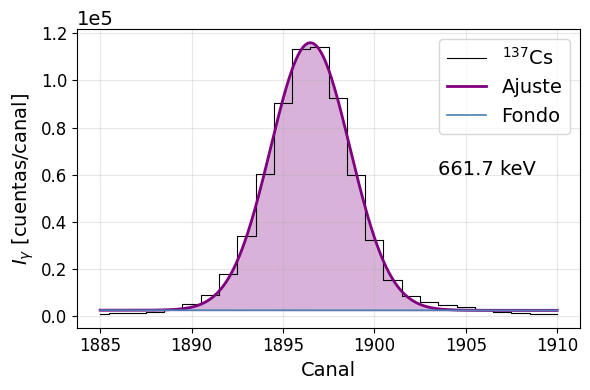

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

# Pico de 661 keV
x_min, x_max = 1885, 1910
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{137}$Cs)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='$^{137}$Cs')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(1903.5, 0.6*1e5, '661.7 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Cobalto 60 "primero" 1173.2 keV


=== Parámetros ===
μ        = 3307.216(15)
σ        = 2.459(18)
FWHM     = 5.767(42)
Int      = 100533(92)


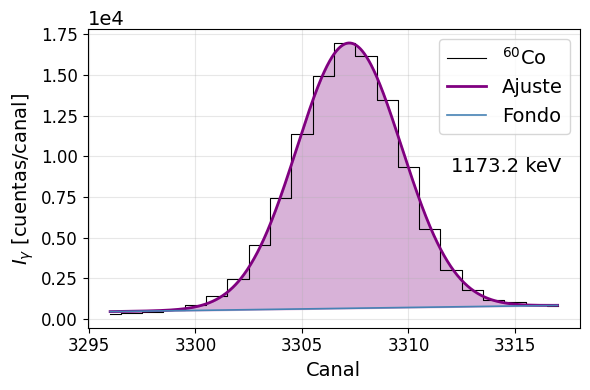

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

# Pico de 661 keV
x_min, x_max = 3296, 3317
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{60}$Co)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='$^{60}$Co')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(3312, 0.9*1e4, '1173.2 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Cobalto 60 "segundo" 1332.5 keV


=== Parámetros ===
μ        = 3746.453(15)
σ        = 2.569(17)
FWHM     = 6.026(39)
Int      = 91685(75)


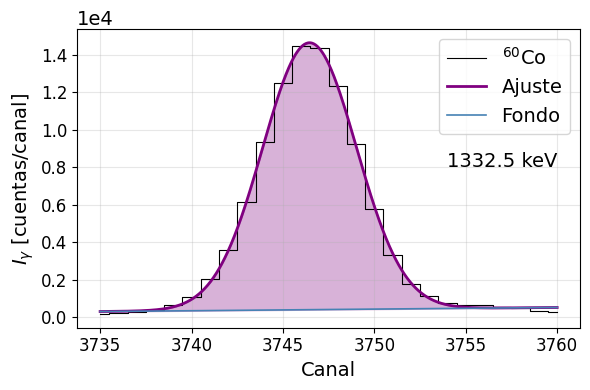

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

# Pico de 661 keV
x_min, x_max = 3735, 3760
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{60}$Co)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='$^{60}$Co')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(3754, 0.8*1e4, '1332.5 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Suma de los picos del Cobalto 60: 1173.2 keV + 1332.5 keV = 2505.7 keV


=== Parámetros ===
μ        = 6982.469(62)
σ        = 3.188(72)
FWHM     = 7.48(17)
Int      = 3737(11)


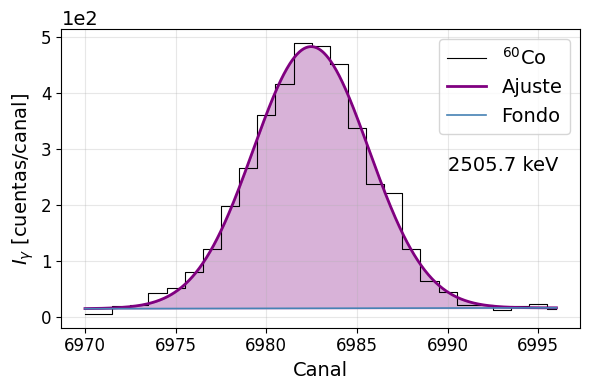

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

# Pico de 661 keV
x_min, x_max = 6970, 6996
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{60}$Co)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='$^{60}$Co')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(6990, 2.6*1e2, '2505.7 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Sodio 22, 1274.5 keV


=== Parámetros ===
μ        = 3746.453(15)
σ        = 2.569(17)
FWHM     = 6.026(39)
Int      = 91685(75)


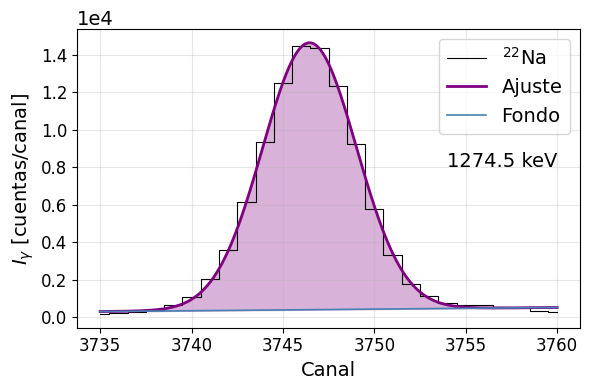

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

# Pico de 661 keV
x_min, x_max = 3735, 3760
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{22}$Na)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='$^{22}$Na')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(3754, 0.8*1e4, '1274.5 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


#Para 152, 154, 155 Eu

Pico de 86.5 keV


=== Parámetros ===
μ        = 312.172(14)
σ        = 1.341(15)
FWHM     = 3.146(36)
Int      = 55744(82)


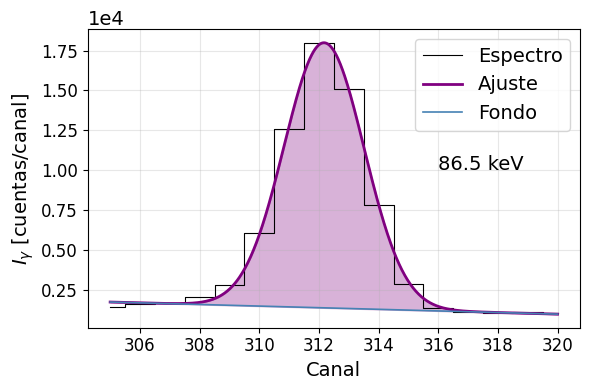

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionEu-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


x_min, x_max = 305, 320
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{155}$Eu)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='Espectro')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(316, 1e4, '86.5 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Pico de 105.3 keV


=== Parámetros ===
μ        = 363.700(11)
σ        = 1.384(12)
FWHM     = 3.247(29)
Int      = 46875(52)


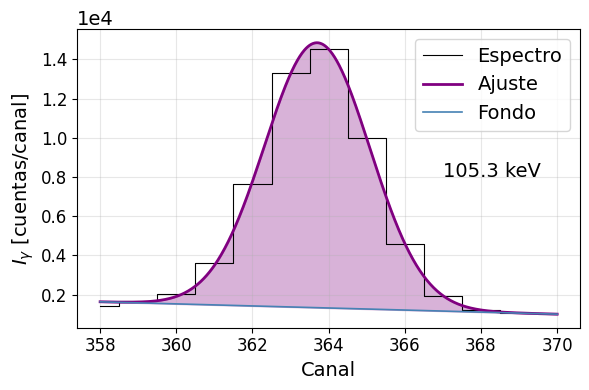

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionEu-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


x_min, x_max = 358, 370
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{154}$Eu)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='Espectro')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(367, 0.8*1e4, '105.3 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Pico de 344.3 keV


=== Parámetros ===
μ        = 1020.1101(71)
σ        = 1.7258(81)
FWHM     = 4.048(19)
Int      = 59375(35)


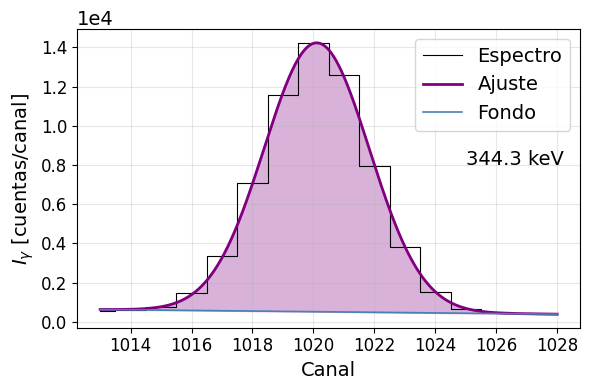

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionEu-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


x_min, x_max = 1013, 1028
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{152}$Eu)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='Espectro')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(1025, 0.8*1e4, '344.3 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Pico de 723.3 keV


=== Parámetros ===
μ        = 2062.905(13)
σ        = 2.053(14)
FWHM     = 4.817(34)
Int      = 15994(14)


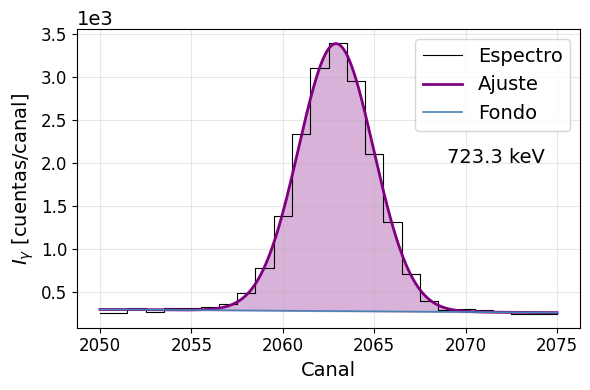

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionEu-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


x_min, x_max = 2050, 2075
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{154}$Eu)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='Espectro')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(2069, 2*1e3, '723.3 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Pico de 964.1 keV


=== Parámetros ===
μ        = 2725.833(19)
σ        = 2.244(21)
FWHM     = 5.263(50)
Int      = 13708(17)


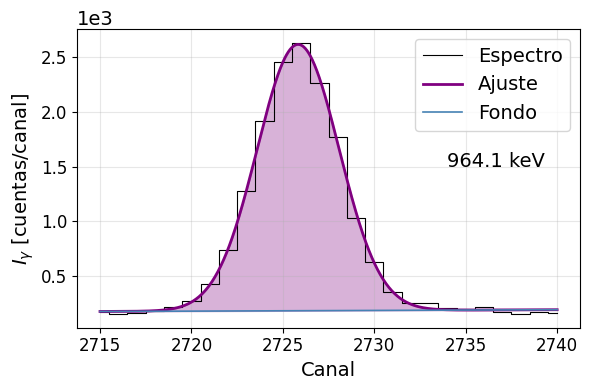

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionEu-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


x_min, x_max = 2715, 2740
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{152}$Eu)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='Espectro')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(2734, 1.5*1e3, '964.1 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Pico de 1274.5 keV


=== Parámetros ===
μ        = 3580.551(15)
σ        = 2.434(17)
FWHM     = 5.709(41)
Int      = 21281(19)


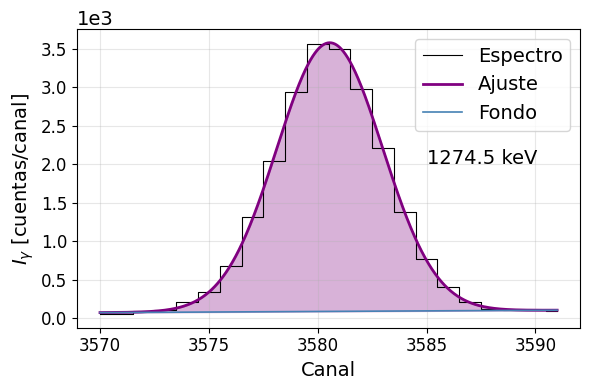

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionEu-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


x_min, x_max = 3570, 3591
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{152}$Eu)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='Espectro')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(3585, 2*1e3, '1274.5 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Pico de 1596.5


=== Parámetros ===
μ        = 4467.266(37)
σ        = 2.700(42)
FWHM     = 6.334(98)
Int      = 1746(34)


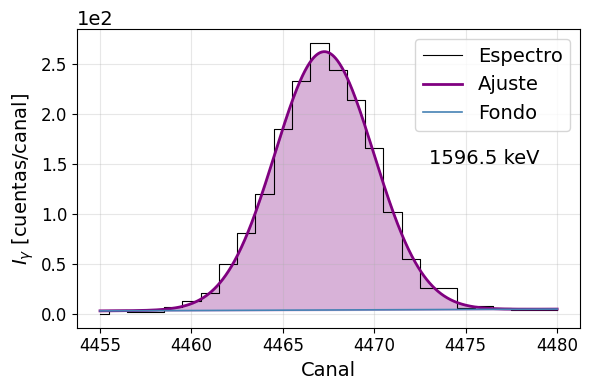

In [ ]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionEu-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"


x_min, x_max = 4455, 4480
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{154}$Eu)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='Espectro')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(4473, 1.5*1e2, '1596.5 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


#$E_\gamma$ [keV] vs Energía [Canal]

=== Ajuste de canal vs energía ===
b0 = 71.803 ± 0.476
b1 = 2.75624 ± 0.00042
-0.00015743732885893741

=== Resultados de la calibración en energía ===
a0 = -26.05(017) keV
a1 = 0.362814(55e) keV/canal

Ecuación de calibración:
E = -26.05(017) + 0.362814(55e) * canal
Acomodar la incertidumbre de a0 a (2) y despreciar la de a1.


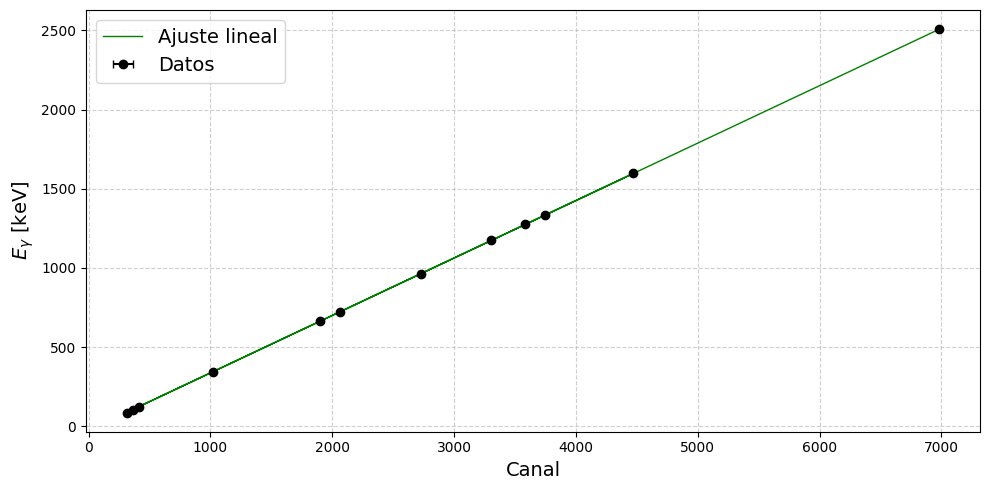


=== Comparación Energía Teórica vs Ajustada ===
   Canal    E_teórico (keV)     E_ajustado (keV)     ΔE (keV)    Error %
  312.10             86.500               87.183       -0.683      0.790
  363.70            105.300              105.904       -0.604      0.574
 1020.11            344.300              344.059        0.241      0.070
 2062.91            723.300              722.399        0.901      0.125
 2725.83            964.100              962.917        1.183      0.123
 3580.55           1274.500             1273.022        1.478      0.116
 4467.27           1596.500             1594.734        1.766      0.111
  410.62            122.100              122.928       -0.828      0.678
 1896.49            661.700              662.021       -0.321      0.049
 3307.22           1173.200             1173.852       -0.652      0.056
 3746.45           1332.500             1333.213       -0.713      0.054
 6982.97           2505.700             2507.466       -1.766      0.070

=

In [16]:
E = np.array([86.5, 105.3, 344.3, 723.3, 964.1, 1274.5, 1596.5, 122.1, 661.7, 1173.2, 1332.5, 2505.7])                                # datos de energía tomados de las tablas
mu = np.array([312.1, 363.7, 1020.1101, 2062.905, 2725.83, 3580.551, 4467.266, 410.622, 1896.49, 3307.216, 3746.453, 6982.97])      # datos de mu hallados en los ajustes
dmu = np.array([0.2, 0.1, 0.0071, 0.013, 0.02, 0.015, 0.037, 0.032, 0.02, 0.015, 0.015, 0.06])                                         # incertidumbres asociadas a cada canal
dE = np.ones_like(E)                                                                                                                          # incertidumbre fija para la energía


def f(E, b0, b1):
    return b0 + b1 * E                                                                                # canal = b0 + b1 * energía

popt, pcov = curve_fit(f, E, mu, sigma=dE, absolute_sigma=True)
b0, b1 = popt
db0, db1 = np.sqrt(np.diag(pcov))

print("=== Ajuste de canal vs energía ===")
print(f"b0 = {b0:.3f} ± {db0:.3f}")
print(f"b1 = {b1:.5f} ± {db1:.5f}")
print(pcov[0,1])

# invierto
# E = a0 + a1 * canal
a1 = 1 / b1
a0 = -b0 / b1
da1 = db1 / b1**2
da0 = np.sqrt((db0/b1)**2 + (b0*db1/b1**2)**2)


def format_uncertainty(value, uncertainty):
    n_decimals = int(-np.floor(np.log10(uncertainty))) + 1
    value_rounded = round(value, n_decimals)
    uncertainty_rounded = round(uncertainty, n_decimals)
    digits = str(uncertainty_rounded).replace('.', '')[:3]
    return f"{value_rounded:.{n_decimals}f}({digits})"

a0_str = format_uncertainty(a0, da0)
a1_str = format_uncertainty(a1, da1)

print("\n=== Resultados de la calibración en energía ===")
print(f"a0 = {a0_str} keV")
print(f"a1 = {a1_str} keV/canal")
print(f"\nEcuación de calibración:")
print(f"E = {a0_str} + {a1_str} * canal")
print(f"Acomodar la incertidumbre de a0 a (2) y despreciar la de a1.")


plt.figure(figsize=(10,5))
plt.errorbar(mu, E, xerr=dmu, fmt='o', color='black', capsize=3, label='Datos')
plt.plot(mu, a0 + a1*mu, color='green', lw=1, label='Ajuste lineal')
plt.xlabel('Canal', fontsize=14)
plt.ylabel('$E_{\\gamma}$ [keV]', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()


E_ajustado = a0 + a1 * mu
dif = E - E_ajustado
error_rel = np.abs(dif / E) * 100

print("\n=== Comparación Energía Teórica vs Ajustada ===")
print(f"{'Canal':>8} {'E_teórico (keV)':>18} {'E_ajustado (keV)':>20} {'ΔE (keV)':>12} {'Error %':>10}")
for i in range(len(E)):
    print(f"{mu[i]:8.2f} {E[i]:18.3f} {E_ajustado[i]:20.3f} {dif[i]:12.3f} {error_rel[i]:10.3f}")


# me falta calcular FHWM [keV]
sigma = np.array([1.341, 1.384, 1.7258, 2.053, 2.244, 2.434, 2.71, 1.638, 2.173, 2.46, 2.57, 3.188])         # ejemplo: σ en canales para cada pico
d_sigma = np.array([0.015, 0.012, 0.0081, 0.014, 0.021, 0.017, 0.04, 0.035, 0.022, 0.02, 0.02, 0.072])                                         # incertidumbre en σ

# FWHM en canales
FWHM_canal = 2.35482 * sigma
dFWHM_canal = 2.35482 * d_sigma

# FWHM en energía (keV)
FWHM_E = a1 * FWHM_canal
dFWHM_E = a1 * dFWHM_canal

# === Mostrar tabla resumen ===
print("\n=== Tabla: Resolución de picos === solo tomar FWHM de acá")
print(f"{'E_teórico (keV)':>16} {'σ (canales)':>14} {'FWHM (canales)':>18} {'FWHM (keV)':>14} {'Resolución (%)':>16}")
for i in range(len(E)):
    resol = (FWHM_E[i] / E[i]) * 100
    print(f"{E[i]:16.2f} {sigma[i]:14.3f} {FWHM_canal[i]:18.3f} {FWHM_E[i]:14.3f} {resol:16.2f}")


Ajuste FWHM con $\sqrt{E_\gamma}$

<>:54: SyntaxWarning: invalid escape sequence '\g'
<>:54: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-230631604.py:54: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(np.sqrt(E_fit), g(E_fit, *popt2), color='steelblue', lw=2, label='FWHM$ = f_0 + f_1 \\sqrt{E_\gamma}$')


=== Calibración Energía-Canal ===
a0 = -26.0511 ± 0.1726
a1 = 0.362814 ± 0.000055
E = -26.051 + 0.362814 * canal

=== Ajuste FWHM = c0 + c1√E ===
f0 = 0.804 ± 0.010
f1 = 0.037 ± 0.000
En el documento poner: f0 = 0.804(1) y f1 = 0.037


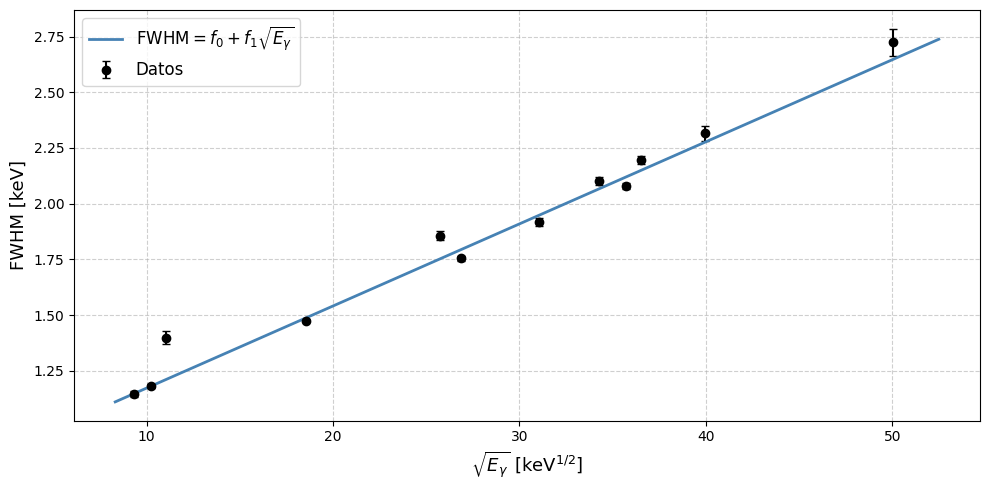


=== Tabla de FWHM ===
   E (keV)     FWHM [keV]      ΔFWHM [keV]    √E [keV¹ᐟ²]
     86.50          1.146            0.013          9.301
    105.30          1.182            0.010         10.262
    344.30          1.474            0.007         18.555
    723.30          1.754            0.012         26.894
    964.10          1.917            0.018         31.050
   1274.50          2.080            0.015         35.700
   1596.50          2.315            0.034         39.956
    122.10          1.399            0.030         11.050
    661.70          1.857            0.019         25.724
   1173.20          2.102            0.017         34.252
   1332.50          2.196            0.017         36.503
   2505.70          2.724            0.062         50.057

=== R^2 del ajuste FWHM = c0 + c1√E ===
R² = 0.975499


In [ ]:
E = np.array([86.5, 105.3, 344.3, 723.3, 964.1, 1274.5, 1596.5, 122.1, 661.7, 1173.2, 1332.5, 2505.7])                                # datos de energía tomados de las tablas
mu = np.array([312.1, 363.7, 1020.1101, 2062.905, 2725.83, 3580.551, 4467.266, 410.622, 1896.49, 3307.216, 3746.453, 6982.97])      # datos de mu hallados en los ajustes
dmu = np.array([0.2, 0.1, 0.0071, 0.013, 0.02, 0.015, 0.037, 0.032, 0.02, 0.015, 0.015, 0.06])                                         # incertidumbres asociadas a cada canal
dE = np.ones_like(E)                                                                                                                          # incertidumbre fija para la energía


# ajuste previo
def f(E, b0, b1):
    return b0 + b1 * E

popt, pcov = curve_fit(f, E, mu, sigma=dE, absolute_sigma=True)
b0, b1 = popt
db0, db1 = np.sqrt(np.diag(pcov))

# inversión
a1 = 1 / b1
a0 = -b0 / b1
da1 = db1 / b1**2
da0 = np.sqrt((db0/b1)**2 + (b0*db1/b1**2)**2)

print("=== Calibración Energía-Canal ===")
print(f"a0 = {a0:.4f} ± {da0:.4f}")
print(f"a1 = {a1:.6f} ± {da1:.6f}")
print(f"E = {a0:.3f} + {a1:.6f} * canal")


# cálculo del FWHM con los valores obtenidos en los ajustes de gaussianas
sigma = np.array([1.341, 1.384, 1.7258, 2.053, 2.244, 2.434, 2.71, 1.638, 2.173, 2.46, 2.57, 3.188])
d_sigma = np.array([0.015, 0.012, 0.0081, 0.014, 0.021, 0.017, 0.04, 0.035, 0.022, 0.02, 0.02, 0.072])


FWHM_canal = 2.35482 * sigma
dFWHM_canal = 2.35482 * d_sigma
FWHM_E = a1 * FWHM_canal
dFWHM_E = a1 * dFWHM_canal

# Ajuste del FWHM con la raíz de la energía
def g(E, c0, c1):
    return c0 + c1 * np.sqrt(E)

popt2, pcov2 = curve_fit(g, E, FWHM_E, sigma=dFWHM_E, absolute_sigma=True)
c0, c1 = popt2
dc0, dc1 = np.sqrt(np.diag(pcov2))

print("\n=== Ajuste FWHM = c0 + c1√E ===")
print(f"f0 = {c0:.3f} ± {dc0:.3f}")
print(f"f1 = {c1:.3f} ± {dc1:.3f}")
print(f"En el documento poner: f0 = 0.804(1) y f1 = 0.037")


E_fit = np.linspace(min(E)*0.8, max(E)*1.1, 300)
plt.figure(figsize=(10,5))
plt.errorbar(np.sqrt(E), FWHM_E, yerr=dFWHM_E, fmt='o', color='black', capsize=3, label='Datos')
plt.plot(np.sqrt(E_fit), g(E_fit, *popt2), color='steelblue', lw=2, label='FWHM$ = f_0 + f_1 \\sqrt{E_\gamma}$')
plt.xlabel(r'$\sqrt{E_\gamma}$ [keV$^{1/2}$]', fontsize=13)
plt.ylabel('FWHM [keV]', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()


print("\n=== Tabla de FWHM ===")
print(f"{'E (keV)':>10} {'FWHM [keV]':>14} {'ΔFWHM [keV]':>16} {'√E [keV¹ᐟ²]':>14}")
for Ei, FH, dFH in zip(E, FWHM_E, dFWHM_E):
    print(f"{Ei:10.2f} {FH:14.3f} {dFH:16.3f} {np.sqrt(Ei):14.3f}")

# ===== Cálculo del R^2 del ajuste FWHM vs sqrt(E) =====

# valores observados
y_obs = FWHM_E

# valores ajustados
y_fit = g(E, *popt2)

# media de los datos
y_mean = np.mean(y_obs)

# suma de cuadrados
SS_res = np.sum((y_obs - y_fit)**2)
SS_tot = np.sum((y_obs - y_mean)**2)

R2 = 1 - SS_res / SS_tot

print(f"\n=== R^2 del ajuste FWHM = c0 + c1√E ===")
print(f"R² = {R2:.6f}")



Ajuste FWHM con $E_\gamma$

=== Calibración Energía-Canal ===
a0 = -26.0511 ± 0.1726
a1 = 0.362814 ± 0.000055
E = -26.051 + 0.362814 * canal

=== Ajuste FWHM = c0 + c1E ===
l0 = 1.173 ± 0.006
l1 = 0.001 ± 0.000
En el documento poner: l0 = 0.804(1) y l1 = 0.037


<>:54: SyntaxWarning: invalid escape sequence '\g'
<>:54: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-644897666.py:54: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(np.sqrt(E_fit), g(E_fit, *popt2), color='steelblue', lw=2, label='FWHM $= l_0 + l_1 E_\gamma$')


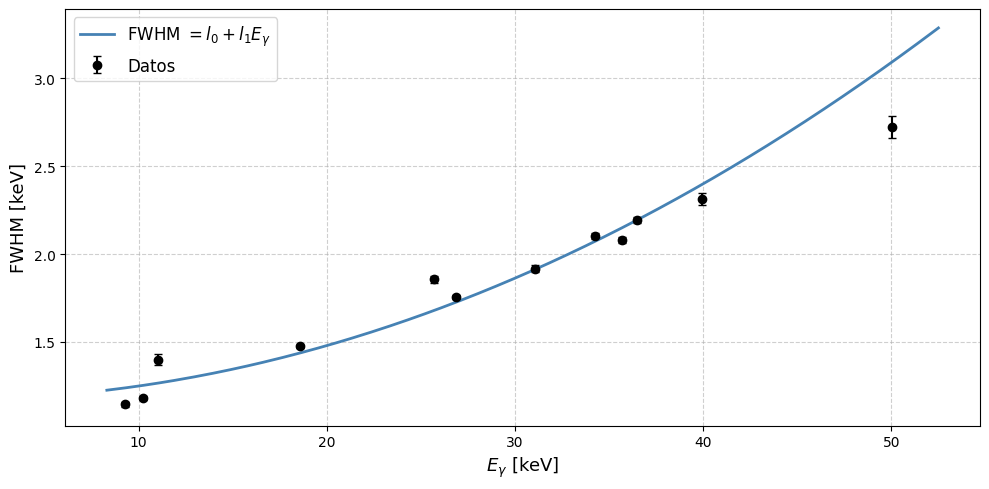


=== Tabla de FWHM ===
   E (keV)     FWHM [keV]      ΔFWHM [keV]          [keV]
     86.50          1.146            0.013          9.301
    105.30          1.182            0.010         10.262
    344.30          1.474            0.007         18.555
    723.30          1.754            0.012         26.894
    964.10          1.917            0.018         31.050
   1274.50          2.080            0.015         35.700
   1596.50          2.315            0.034         39.956
    122.10          1.399            0.030         11.050
    661.70          1.857            0.019         25.724
   1173.20          2.102            0.017         34.252
   1332.50          2.196            0.017         36.503
   2505.70          2.724            0.062         50.057

=== R^2 del ajuste FWHM = l0 + l1E ===
R² = 0.915110


In [ ]:
E = np.array([86.5, 105.3, 344.3, 723.3, 964.1, 1274.5, 1596.5, 122.1, 661.7, 1173.2, 1332.5, 2505.7])                                # datos de energía tomados de las tablas
mu = np.array([312.1, 363.7, 1020.1101, 2062.905, 2725.83, 3580.551, 4467.266, 410.622, 1896.49, 3307.216, 3746.453, 6982.97])      # datos de mu hallados en los ajustes
dmu = np.array([0.2, 0.1, 0.0071, 0.013, 0.02, 0.015, 0.037, 0.032, 0.02, 0.015, 0.015, 0.06])                                         # incertidumbres asociadas a cada canal
dE = np.ones_like(E)                                                                                                                          # incertidumbre fija para la energía


# ajuste previo
def f(E, b0, b1):
    return b0 + b1 * E

popt, pcov = curve_fit(f, E, mu, sigma=dE, absolute_sigma=True)
b0, b1 = popt
db0, db1 = np.sqrt(np.diag(pcov))

# inversión
a1 = 1 / b1
a0 = -b0 / b1
da1 = db1 / b1**2
da0 = np.sqrt((db0/b1)**2 + (b0*db1/b1**2)**2)

print("=== Calibración Energía-Canal ===")
print(f"a0 = {a0:.4f} ± {da0:.4f}")
print(f"a1 = {a1:.6f} ± {da1:.6f}")
print(f"E = {a0:.3f} + {a1:.6f} * canal")


# cálculo del FWHM con los valores obtenidos en los ajustes de gaussianas
sigma = np.array([1.341, 1.384, 1.7258, 2.053, 2.244, 2.434, 2.71, 1.638, 2.173, 2.46, 2.57, 3.188])
d_sigma = np.array([0.015, 0.012, 0.0081, 0.014, 0.021, 0.017, 0.04, 0.035, 0.022, 0.02, 0.02, 0.072])


FWHM_canal = 2.35482 * sigma
dFWHM_canal = 2.35482 * d_sigma
FWHM_E = a1 * FWHM_canal
dFWHM_E = a1 * dFWHM_canal

# Ajuste del FWHM con la raíz de la energía
def g(E, c0, c1):
    return c0 + c1 * E

popt2, pcov2 = curve_fit(g, E, FWHM_E, sigma=dFWHM_E, absolute_sigma=True)
c0, c1 = popt2
dc0, dc1 = np.sqrt(np.diag(pcov2))

print("\n=== Ajuste FWHM = c0 + c1E ===")
print(f"l0 = {c0:.3f} ± {dc0:.3f}")
print(f"l1 = {c1:.3f} ± {dc1:.3f}")
print(f"En el documento poner: l0 = 0.804(1) y l1 = 0.037")


E_fit = np.linspace(min(E)*0.8, max(E)*1.1, 300)
plt.figure(figsize=(10,5))
plt.errorbar(np.sqrt(E), FWHM_E, yerr=dFWHM_E, fmt='o', color='black', capsize=3, label='Datos')
plt.plot(np.sqrt(E_fit), g(E_fit, *popt2), color='steelblue', lw=2, label='FWHM $= l_0 + l_1 E_\gamma$')
plt.xlabel(r'$E_\gamma$ [keV]', fontsize=13)
plt.ylabel('FWHM [keV]', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()


print("\n=== Tabla de FWHM ===")
print(f"{'E (keV)':>10} {'FWHM [keV]':>14} {'ΔFWHM [keV]':>16} {' [keV]':>14}")
for Ei, FH, dFH in zip(E, FWHM_E, dFWHM_E):
    print(f"{Ei:10.2f} {FH:14.3f} {dFH:16.3f} {np.sqrt(Ei):14.3f}")

# ===== Cálculo del R^2 del ajuste FWHM vs E =====

# valores observados
y_obs = FWHM_E

# valores ajustados
y_fit = g(E, *popt2)

# media de los datos
y_mean = np.mean(y_obs)

# suma de cuadrados
SS_res = np.sum((y_obs - y_fit)**2)
SS_tot = np.sum((y_obs - y_mean)**2)

R2 = 1 - SS_res / SS_tot

print(f"\n=== R^2 del ajuste FWHM = l0 + l1E ===")
print(f"R² = {R2:.6f}")



# Eficiencia


In [ ]:
!pip install uncertainties

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 976.8 kB/s eta 0:00:00


In [ ]:
from uncertainties import ufloat
from uncertainties.umath import exp
import numpy as np
from datetime import datetime

In [ ]:
def A(A0, dt, tau):
    return A0 * exp(-dt / tau)


def delta_t(fecha_nucleido):
    fecha_experimento = datetime(2018, 5, 29)
    fecha_ref = datetime.strptime(fecha_nucleido, "%Y-%m-%d")
    delta = fecha_experimento - fecha_ref
    return delta.days                                             # devuelve Δt en días

def epsilon(I,A,b):
    return I/(A*b)

def tau_c(T12):
    return T12/np.log(2)

In [ ]:
# Porcentaje b (valor dividido entre 100)
b86 = ufloat(0.031, 0.0)           # 86.5 keV
b105 = ufloat(0.022, 0.0)          # 105.3 keV
b344 = ufloat(0.2657, 0.0)         # 344.28 keV
b723 = ufloat(0.202, 0.0)          # 723.3 keV
b964 = ufloat(0.1463, 0.0)         # 964.1 keV
b1274 = ufloat(0.35, 0.0)          # 1274.5 keV
b1596 = ufloat(0.0181, 0.0)        # 1596.48 keV


# Actividades iniciales A0 (en kBq) y fechas de referencia (que en este caso son todas la misma)
A0_86 = ufloat(12.8, 0.0)
A0_105 = ufloat(12.8, 0.0)
A0_344 = ufloat(7.65, 0.0)
A0_723 = ufloat(8.45, 0.0)
A0_964 = ufloat(7.65, 0.0)
A0_1274 = ufloat(8.45, 0.0)
A0_1596 = ufloat(8.45, 0.0)

fecha = datetime(2006,7,13)

DAYS_PER_YEAR = 365 # De ser necesario calcular los dias con valores decimales.

# Vida media de cada nucleido en dias

N0_86 = ufloat(4.76 * DAYS_PER_YEAR, 0.0)
N0_105 = ufloat(4.76 * DAYS_PER_YEAR, 0.0)
N0_344 = ufloat(13.6 * DAYS_PER_YEAR, 0.0)
N0_723 = ufloat(8.59 * DAYS_PER_YEAR, 0.0)
N0_964 = ufloat(13.6 * DAYS_PER_YEAR, 0.0)
N0_1274 = ufloat(8.59 * DAYS_PER_YEAR, 0.0)
N0_1596 = ufloat(8.59 * DAYS_PER_YEAR, 0.0)

# Calculo de tau en dias

tau_86  = tau_c(N0_86)
tau_105 = tau_c(N0_105)
tau_344 = tau_c(N0_344)
tau_723 = tau_c(N0_723)
tau_964 = tau_c(N0_964)
tau_1274 = tau_c(N0_1274)
tau_1596 = tau_c(N0_1596)

# Iγ (cuentas) por energía
I_86  = ufloat(55744, 82)
I_105 = ufloat(46875, 52)
I_344 = ufloat(59375, 35)
I_723 = ufloat(15994, 14)
I_964 = ufloat(13708, 17)
I_1274 = ufloat(21281, 19)
I_1596 = ufloat(1746, 34)

/usr/local/lib/python3.12/dist-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [ ]:

# Δt entre fechas (en días)

dt_86 = delta_t("2006-07-13")
dt_105 = delta_t("2006-07-13")
dt_344 = delta_t("2006-07-13")
dt_723 = delta_t("2006-07-13")
dt_964 = delta_t("2006-07-13")
dt_1274 = delta_t("2006-07-13")
dt_1596 = delta_t("2006-07-13")

# Actividades A(t) en 2018-05-29

A_86  = A(A0_86, dt_86, tau_86)
A_105 = A(A0_105, dt_105, tau_105)
A_344 = A(A0_344, dt_344, tau_344)
A_723 = A(A0_723, dt_723, tau_723)
A_964 = A(A0_964, dt_964, tau_964)
A_1274 = A(A0_1274, dt_1274, tau_1274)
A_1596 = A(A0_1596, dt_1596, tau_1596)


# Actividad gamma

Ag_86  = A_86 * b86
Ag_105 = A_105 * b105
Ag_344 = A_344 * b344
Ag_723 = A_723 * b723
Ag_964 = A_964 * b964
Ag_1274 = A_1274 * b1274
Ag_1596 = A_1596 * b1596


# Cálculo de eficiencias ep = I / (A * b)

ep_86  = I_86 / Ag_86
ep_105 = I_105 / Ag_105
ep_344 = I_344 / Ag_344
ep_723 = I_723 / Ag_723
ep_964 = I_964 / Ag_964
ep_1274 = I_1274 / Ag_1274
ep_1596 = I_1596 / Ag_1596


def fmtA_unc(x):
    return f"{x:.2uS}"  # imprime con incertidumbre tipo 1.234(15)

print("Resultados al 05-09-2018:\n")

print(f"86.5 keV (155Eu)  : A = {fmtA_unc(A_86)} kBq,   Aγ = {fmtA_unc(Ag_86)} kBq,   ep = {ep_86:.2uS} cuentas/kBq")
print(f"105.3  keV (155Eu)  : A = {fmtA_unc(A_105)} kBq,   Aγ = {fmtA_unc(Ag_105)} kBq,   ep = {ep_105:.2uS} cuentas/kBq")
print(f"344.28 keV (152Eu): A = {fmtA_unc(A_344)} kBq,   Aγ = {fmtA_unc(Ag_344)} kBq,   ep = {ep_344:.2uS} cuentas/kBq")
print(f"723.30 keV (154Eu)  : A = {fmtA_unc(A_723)} kBq,  Aγ = {fmtA_unc(Ag_723)} kBq,  ep = {ep_723:.2uS} cuentas/kBq")
print(f"964.1 keV (152Eu)  : A = {fmtA_unc(A_964)} kBq,  Aγ = {fmtA_unc(Ag_964)} kBq,  ep = {ep_964:.2uS} cuentas/kBq")
print(f"1274.43 keV (154Eu)  : A = {fmtA_unc(A_1274)} kBq,  Aγ = {fmtA_unc(Ag_1274)} kBq,  ep = {ep_1274:.2uS} cuentas/kBq")
print(f"1596.48 keV (154Eu)  : A = {fmtA_unc(A_1596)} kBq,  Aγ = {fmtA_unc(Ag_1596)} kBq,  ep = {ep_1596:.2uS} cuentas/kBq")



Resultados al 05-09-2018:

86.5 keV (155Eu)  : A = 2.26771219751504(0) kBq,   Aγ = 0.07029907812296624(0) kBq,   ep = 7.930(12)e+05 cuentas/kBq
105.3  keV (155Eu)  : A = 2.26771219751504(0) kBq,   Aγ = 0.04988966834533087(0) kBq,   ep = 9.396(10)e+05 cuentas/kBq
344.28 keV (152Eu): A = 4.174396747664144(0) kBq,   Aγ = 1.1091372158543629(0) kBq,   ep = 53533(32) cuentas/kBq
723.30 keV (154Eu)  : A = 3.2386077642659394(0) kBq,  Aγ = 0.6541987683817198(0) kBq,  ep = 24448(21) cuentas/kBq
964.1 keV (152Eu)  : A = 4.174396747664144(0) kBq,  Aγ = 0.6107142441832643(0) kBq,  ep = 22446(28) cuentas/kBq
1274.43 keV (154Eu)  : A = 3.2386077642659394(0) kBq,  Aγ = 1.1335127174930788(0) kBq,  ep = 18774(17) cuentas/kBq
1596.48 keV (154Eu)  : A = 3.2386077642659394(0) kBq,  Aγ = 0.05861880053321351(0) kBq,  ep = 2.979(58)e+04 cuentas/kBq


Eficiencias reales (sin normalizar):
   86.5 keV  ->  ep = 7.930(12)e+05
  105.3 keV  ->  ep = 9.396(10)e+05
  344.3 keV  ->  ep = 53533(32)
  723.3 keV  ->  ep = 24448(21)
  964.1 keV  ->  ep = 22446(28)
 1274.4 keV  ->  ep = 18774(17)
 1596.5 keV  ->  ep = 2.979(58)e+04
Máximo: Eγ = 105.3 keV  (ep_max = 9.396(10)e+05)

Eficiencias normalizadas (valor(inc)):
E =    86.5 keV  →  ep_norm = 0.8440(12)
E =   105.3 keV  →  ep_norm = 1.0000(11)
E =   344.3 keV  →  ep_norm = 0.056975(34)
E =   723.3 keV  →  ep_norm = 0.026021(23)
E =   964.1 keV  →  ep_norm = 0.023889(30)
E =  1274.4 keV  →  ep_norm = 0.019982(18)
E =  1596.5 keV  →  ep_norm = 0.03170(62)


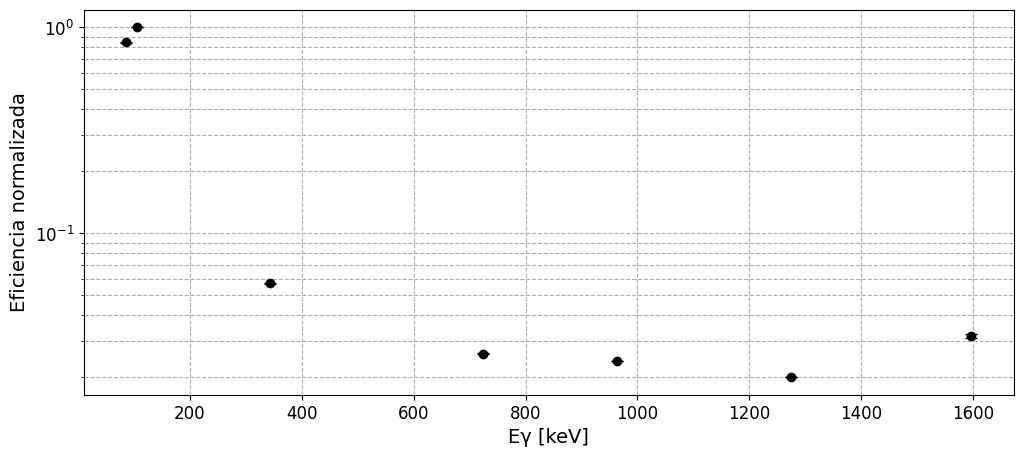

In [ ]:
from uncertainties import unumpy as unp
import matplotlib.pyplot as plt

# Epsilon normalizado
E_keV = np.array([86.5, 105.3, 344.28, 723.30, 964.1, 1274.43, 1596.48])
eps   = np.array([ep_86, ep_105, ep_344, ep_723, ep_964, ep_1274, ep_1596], dtype=object)

print("Eficiencias reales (sin normalizar):")
for Ei, ei in zip(E_keV, eps):
    print(f"{Ei:7.1f} keV  ->  ep = {ei:.2uS}")

eps_nom = unp.nominal_values(eps)
imax    = int(np.argmax(eps_nom))
epmax_nom = eps_nom[imax]          # escalar (sin incertidumbre), así el máximo queda exactamente 1

eps_norm = eps / epmax_nom
epsn_nom = unp.nominal_values(eps_norm)
epsn_std = unp.std_devs(eps_norm)

print(f"Máximo: Eγ = {E_keV[imax]} keV  (ep_max = {eps[imax]:.2uS})")
print("\nEficiencias normalizadas (valor(inc)):")
for Ei, en in zip(E_keV, eps_norm):
    print(f"E = {Ei:7.1f} keV  →  ep_norm = {en:.2uS}")

# Gráfica semilog
plt.figure(figsize=(12,5))
plt.errorbar(E_keV, epsn_nom, yerr=epsn_std, fmt='o', capsize=4, label="Datos experimentales", color='black')
plt.yscale("log")  # ← Esto convierte el eje Y a escala logarítmica
plt.xlabel("Eγ [keV]", fontsize=14)
plt.ylabel("Eficiencia normalizada", fontsize=14)
plt.grid(True, which="both", linestyle="--")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)


#Comparacion entre detectores. Ge vs NaI


=== Parámetros ===
μ        = 410.622(32)
σ        = 1.638(35)
FWHM     = 3.843(81)
Int      = 1126820(31)


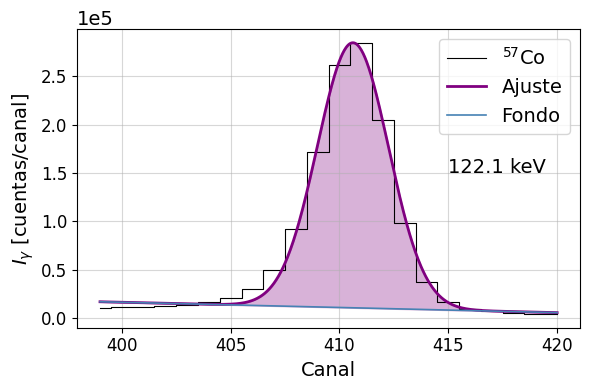

In [12]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

# Pico de 122 keV
x_min, x_max = 399, 420
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{57}$Co)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='$^{57}$Co')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(415, 1.5*1e5, '122.1 keV', fontsize=14)
    ax.grid(alpha=0.5)

    plt.tight_layout()
    plt.show()



=== Parámetros ===
μ        = 450.258(29)
σ        = 1.663(31)
FWHM     = 3.901(74)
Int      = 141722(34)


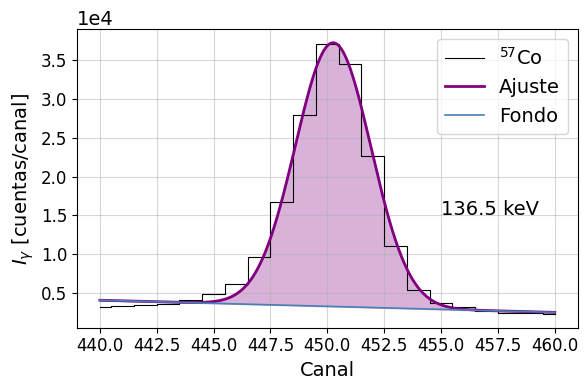

In [11]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

# Pico de 136 keV
x_min, x_max = 440, 460
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{57}$Co)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='$^{57}$Co')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(455, 1.5*1e4, '136.5 keV', fontsize=14)
    ax.grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

In [13]:
archivo_fuente = "NaI_57Co_300s.dat"
archivo_fondo  = "NaI_Fondo_300s.dat"

def leer_datos(ruta):
    try:
        df = pd.read_csv(ruta, delim_whitespace=True, comment='#', header=0)
        cols = df.columns[:2]
        df = df.rename(columns={cols[0]: 'canal', cols[1]: 'cuentas'})
    except Exception:
        df = pd.read_csv(ruta, delim_whitespace=True, comment='#', header=None)
        df = df.iloc[:, :2]
        df.columns = ['canal', 'cuentas']

    df['canal'] = pd.to_numeric(df['canal'], errors='coerce')
    df['cuentas'] = pd.to_numeric(df['cuentas'], errors='coerce')
    df = df.dropna(subset=['canal', 'cuentas']).reset_index(drop=True)
    return df[['canal', 'cuentas']]

# Leer fuente y fondo
nai_src   = leer_datos(archivo_fuente)
nai_fondo = leer_datos(archivo_fondo)

# Alinear por canal y restar fondo
nai = nai_src.merge(nai_fondo, on='canal', suffixes=('_src', '_fondo'))

nai['cuentas_corr'] = nai['cuentas_src'] - nai['cuentas_fondo']

# (Opcional) evitar cuentas negativas después de la resta:
# nai['cuentas_corr'] = nai['cuentas_corr'].clip(lower=0)

canal_NaI = nai['canal'].values
cuentas_NaI = nai['cuentas_corr'].values

# -----------------------------
# Calibración NaI
# -----------------------------
b0 = -55.6
b1 = 3.1973

# Energía calibrada NaI
E_NaI = b0 + b1 * canal_NaI

# =============================
# Ge
# =============================

canal_Ge = varios["canal"].values
cuentas_Ge = varios["cuentas"].values
E_Ge = a0 + a1 * canal_Ge    # E = a0 + a1 * canal

# -----------------------------
# FILTRAR 40–220 keV
# -----------------------------

mask_Ge  = (E_Ge  >= 40) & (E_Ge  <= 220)
mask_NaI = (E_NaI >= 40) & (E_NaI <= 220)

E_Ge_plot        = E_Ge[mask_Ge]
cuentas_Ge_plot  = cuentas_Ge[mask_Ge]

E_NaI_plot       = E_NaI[mask_NaI]
cuentas_NaI_plot = cuentas_NaI[mask_NaI]

# -----------------------------
# GRÁFICA NORMALIZADA
# -----------------------------

Ge_max  = np.max(cuentas_Ge_plot)
NaI_max = np.max(cuentas_NaI_plot)

cuentas_Ge_norm  = cuentas_Ge_plot  / Ge_max
cuentas_NaI_norm = cuentas_NaI_plot / NaI_max

plt.figure(figsize=(10, 6))
plt.step(E_Ge_plot,  cuentas_Ge_norm,  label="Ge (normalizado)",color="black",where="mid")
plt.step(E_NaI_plot,cuentas_NaI_norm, label="NaI (sin fondo, normalizado)", color="red",where="mid")

plt.xlabel("Energía [keV]", fontsize=14)
plt.ylabel("$I_\gamma$ (normalizada)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

# -----------------------------
# Picos e intensidades de tabla
# -----------------------------
pico1 = ufloat(122.06065, 0.00012)
pico2 = ufloat(136.47350, 0.00029)
E = np.array([pico1, pico2])

I1 = ufloat(1126820, 31)
I2 = ufloat(141722, 34)


<>:79: SyntaxWarning: invalid escape sequence '\g'
<>:79: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-4224543977.py:79: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ (normalizada)", fontsize=14)
/tmp/ipython-input-4224543977.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ruta, delim_whitespace=True, comment='#', header=0)
/tmp/ipython-input-4224543977.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ruta, delim_whitespace=True, comment='#', header=0)


ValueError: zero-size array to reduction operation maximum which has no identity

2 ) Espectros completos

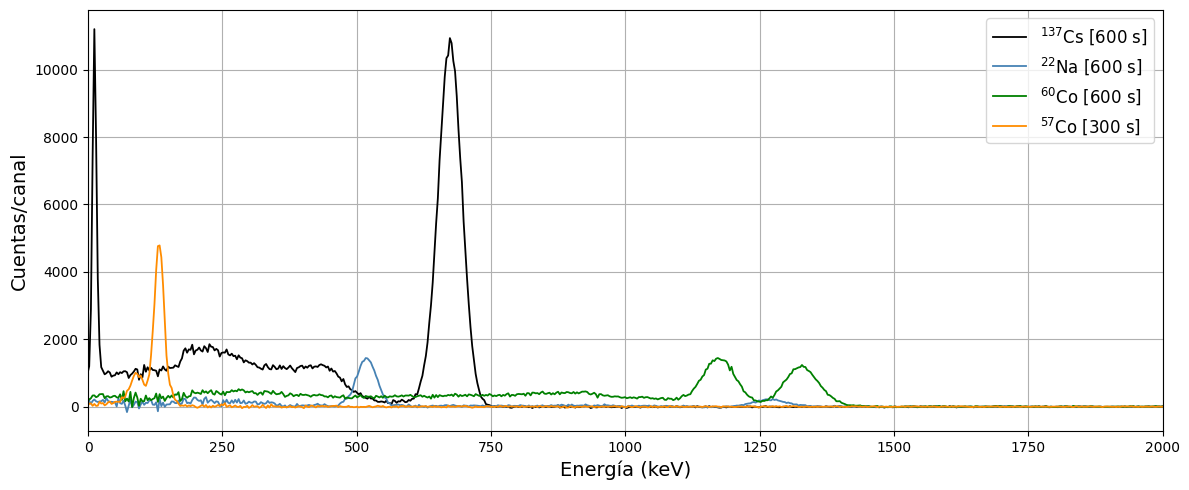

In [8]:
archivos = [
    "NaI_137Cs_600s.dat",
    "NaI_22Na_600s.dat",
    "NaI_60Co_600s.dat",
    "NaI_Fondo_600s.dat",
    "NaI_57Co_300s.dat",
    "NaI_Fondo_300s.dat"
]

colores = ['black', 'steelblue', 'green', 'purple', 'darkorange', 'mediumvioletred']

etiquetas = [
    r"$^{137}$Cs [600 s]",   # NaI_137Cs_600s.dat
    r"$^{22}$Na [600 s]",    # NaI_22Na_600s.dat
    r"$^{60}$Co [600 s]",    # NaI_60Co_600s.dat
    "Fondo 600 s",   # NaI_Fondo_600s.dat
    r"$^{57}$Co [300 s]",    # NaI_57Co_300s.dat
    "Fondo 300 s"    # NaI_Fondo_300s.dat
]

def leer_dat(archivo):
    with open(archivo, 'r', encoding='latin-1') as f:
        lineas = f.readlines()
    lineas_numericas = [l for l in lineas if l.strip() and l.strip()[0].isdigit()]
    from io import StringIO
    data = pd.read_csv(StringIO(''.join(lineas_numericas)), sep=r'\s+', header=None)
    data.columns = ['canal', 'cuentas']
    return data

# fondos (en canales)
fondo_600 = leer_dat("NaI_Fondo_600s.dat")
fondo_300 = leer_dat("NaI_Fondo_300s.dat")

# --- Calibración universal NaI: E(keV) = b0 + b1 * canal ---
b0 = -55.6
b1 = 3.1973

plt.figure(figsize=(12, 5))

for archivo, color, etiqueta in zip(archivos, colores, etiquetas):
    # Solo graficamos los espectros con fuente, no los fondos
    if "Fondo" in archivo:
        continue

    data = leer_dat(archivo)
    canales = data['canal'].values
    cuentas = data['cuentas'].astype(float).values

    # Resta de fondo en CANALES
    if "600s" in archivo:
        y_fondo = np.interp(canales, fondo_600['canal'], fondo_600['cuentas'])
        cuentas_corr = cuentas - y_fondo
    elif "300s" in archivo:
        y_fondo = np.interp(canales, fondo_300['canal'], fondo_300['cuentas'])
        cuentas_corr = cuentas - y_fondo
    else:
        cuentas_corr = cuentas  # por si hubiera algún caso raro
    E = b0 + b1 * canales

    plt.plot(E, cuentas_corr, lw=1.3, color=color, label=etiqueta)

plt.xlabel("Energía (keV)", fontsize=14)
plt.ylabel("Cuentas/canal", fontsize=14)
plt.xlim(0, 2000)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()


<>:95: SyntaxWarning: invalid escape sequence '\g'
<>:96: SyntaxWarning: invalid escape sequence '\g'
<>:95: SyntaxWarning: invalid escape sequence '\g'
<>:96: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3194947783.py:95: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$E_\gamma$ [keV]", fontsize=14)
/tmp/ipython-input-3194947783.py:96: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$", fontsize=14)
/tmp/ipython-input-3194947783.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ruta, delim_whitespace=True, comment='#', header=0)
/tmp/ipython-input-3194947783.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ruta, delim_whitespace=True, comment='#', header=0)
/tmp/ipython-input-3194947783.py:7: FutureWarning:

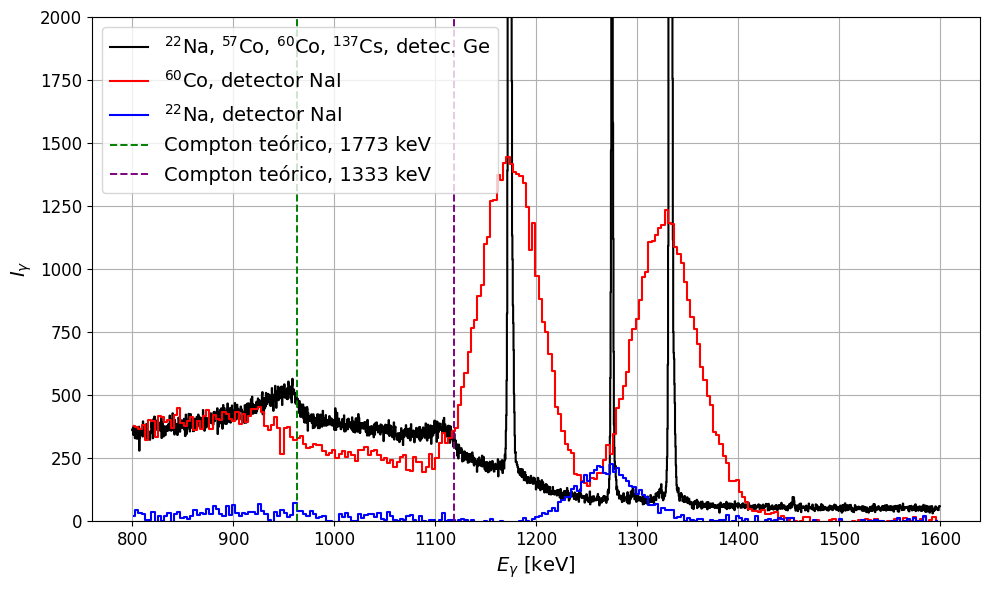

In [19]:
archivo_fuente  = "NaI_60Co_600s.dat"
archivo_fuente2 = "NaI_22Na_600s.dat"
archivo_fondo   = "NaI_Fondo_600s.dat"

def leer_datos(ruta):
    try:
        df = pd.read_csv(ruta, delim_whitespace=True, comment='#', header=0)
        cols = df.columns[:2]
        df = df.rename(columns={cols[0]: 'canal', cols[1]: 'cuentas'})
    except Exception:
        df = pd.read_csv(ruta, delim_whitespace=True, comment='#', header=None)
        df = df.iloc[:, :2]
        df.columns = ['canal', 'cuentas']

    df['canal'] = pd.to_numeric(df['canal'], errors='coerce')
    df['cuentas'] = pd.to_numeric(df['cuentas'], errors='coerce')
    df = df.dropna(subset=['canal', 'cuentas']).reset_index(drop=True)
    return df[['canal', 'cuentas']]

# -----------------------------
# Leer fuentes y fondo
# -----------------------------
nai_src   = leer_datos(archivo_fuente)
nai_src2  = leer_datos(archivo_fuente2)
nai_fondo = leer_datos(archivo_fondo)

# -----------------------------
# RESTA DE FONDO (en canales)
# -----------------------------
nai = nai_src.merge(nai_fondo, on='canal', suffixes=('_src', '_fondo'))
nai['cuentas_corr'] = nai['cuentas_src'] - nai['cuentas_fondo']

nai2 = nai_src2.merge(nai_fondo, on='canal', suffixes=('_src', '_fondo'))
nai2['cuentas_corr'] = nai2['cuentas_src'] - nai2['cuentas_fondo']

canal_NaI  = nai['canal'].values
cuentas_NaI = nai['cuentas_corr'].values

canal_NaI2  = nai2['canal'].values
cuentas_NaI2 = nai2['cuentas_corr'].values

# -----------------------------
# Calibración universal NaI
# -----------------------------
b0 = -55.6
b1 = 3.1973

E_NaI  = b0 + b1 * canal_NaI
E_NaI2 = b0 + b1 * canal_NaI2

# =============================
# Espectro Ge
# =============================
canal_Ge = varios["canal"].values
cuentas_Ge = varios["cuentas"].values
E_Ge = a0 + a1 * canal_Ge

# -----------------------------
# FILTRAR RANGO DE INTERÉS
# -----------------------------
mask_Ge   = (E_Ge  >= 800) & (E_Ge  <= 1600)
mask_NaI  = (E_NaI >= 800) & (E_NaI <= 1600)
mask_NaI2 = (E_NaI2 >= 800) & (E_NaI2 <= 1600)

E_Ge_plot        = E_Ge[mask_Ge]
cuentas_Ge_plot  = cuentas_Ge[mask_Ge]

E_NaI_plot       = E_NaI[mask_NaI]
cuentas_NaI_plot = cuentas_NaI[mask_NaI]

E_NaI2_plot       = E_NaI2[mask_NaI2]
cuentas_NaI2_plot = cuentas_NaI2[mask_NaI2]

# -----------------------------
# GRÁFICA
# -----------------------------
plt.figure(figsize=(10, 6))

plt.step(E_Ge_plot,   cuentas_Ge_plot,   label="$^{22}$Na, $^{57}$Co, $^{60}$Co, $^{137}$Cs, detec. Ge", color="black", where="mid")
plt.step(E_NaI_plot,  cuentas_NaI_plot,  label="$^{60}$Co, detector NaI", color="red", where="mid")
plt.step(E_NaI2_plot, cuentas_NaI2_plot, label="$^{22}$Na, detector NaI", color="blue", where="mid")


# Borde Compton teórico
def borde_compton(E):
    return E * (1 - 1/(1 + 2*E/511))

C1173 = borde_compton(1173)
C1333 = borde_compton(1333)

plt.axvline(C1173, color='green', linestyle='--', lw=1.4, label='Compton teórico, 1773 keV')
plt.axvline(C1333, color='purple', linestyle='--', lw=1.4, label='Compton teórico, 1333 keV')

plt.ylim(0,2000)
plt.xlabel("$E_\gamma$ [keV]", fontsize=14)
plt.ylabel("$I_\gamma$", fontsize=14)
plt.grid(True)
plt.legend(loc= 'upper left',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
